# Multivariate Gaussian Test

In [1]:
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

from collections import OrderedDict
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
# use ggplot styles for graphs
plt.style.use('ggplot')


import arviz as az

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [3]:
# import probabilistic models
from bayes_vi.model import Model

# import utils
from bayes_vi.utils import to_ordered_dict
from bayes_vi.utils.symplectic_integrators import LeapfrogIntegrator
from bayes_vi.utils.datasets import make_dataset_from_df

In [4]:
# mcmc imports
from bayes_vi.inference.mcmc import MCMC
from bayes_vi.inference.mcmc.transition_kernels import HamiltonianMonteCarlo, NoUTurnSampler, RandomWalkMetropolis
from bayes_vi.inference.mcmc.stepsize_adaptation_kernels import SimpleStepSizeAdaptation, DualAveragingStepSizeAdaptation

In [5]:
# vi imports 
from bayes_vi.inference.vi import VI
from bayes_vi.inference.vi.surrogate_posteriors import ADVI, NormalizingFlow
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn

## 1. Generate Test Dataset

In [6]:
dims = 2
num_datapoints = 1000

In [7]:
def likelihood(loc, scale):
    return tfd.MultivariateNormalTriL(loc=loc, scale_tril=scale)

In [8]:
#parameters
loc = tf.constant([1., 7.])
scale = tf.constant([[3., 0.],[7., 4.]])
loc, scale

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 7.], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[3., 0.],
        [7., 4.]], dtype=float32)>)

In [9]:
y = likelihood(loc, scale).sample(num_datapoints)

In [10]:
data = pd.DataFrame({'y{}'.format(i+1): y_i for i, y_i in enumerate(tf.unstack(y, axis=1))})

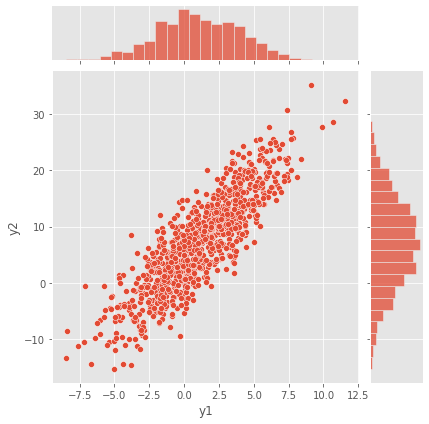

In [11]:
sns.jointplot(x=data['y1'], y=data['y2'])

In [12]:
dataset = make_dataset_from_df(data, target_names=['y1', 'y2'], format_features_as='dict')
dataset

<TensorSliceDataset shapes: ((2,), (2,)), types: (tf.float32, tf.float32)>

## 2. Model

In [13]:
priors = OrderedDict(
    loc = tfd.MultivariateNormalDiag(loc=[0.]*dims, scale_diag=[10.]*dims),
    precision = tfd.WishartTriL(
        df=5,
        scale_tril=10.0*tf.eye(dims),
        input_output_cholesky=True
    )
)

def likelihood(loc, precision): 
    return tfd.MultivariateNormalTriL(
        loc=loc, scale_tril=tf.linalg.cholesky_solve(
            precision, tf.linalg.eye(dims)
        )
    )
    #return MVNCholPrecisionTriL(loc=loc, chol_precision_tril=precision)

constraining_bijectors = [
    tfb.Identity(),
    tfb.FillScaleTriL(diag_bijector=tfb.Softplus(), diag_shift=1e-3)
]

In [14]:
model = Model(priors=priors, likelihood=likelihood, constraining_bijectors=constraining_bijectors)

## 3. Run VI

In [15]:
def get_hamiltonian_flow_bijector(unconstrained_event_dims, num_flows):
    return tfb.Chain([
        HamiltonianFlow(
            event_dims=unconstrained_event_dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=tf.Variable(0.1), 
            num_integration_steps=2,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)
    ])

In [16]:
step_size = tf.Variable(0.1)
scale_fn = make_scale_fn(model.flat_unconstrained_param_event_ndims, hidden_layers=[128,128])
shift_fn = make_shift_fn(model.flat_unconstrained_param_event_ndims, hidden_layers=[128,128])

posterior_lift = lambda q: tfd.MultivariateNormalDiag(loc=shift_fn(q), scale_diag=scale_fn(q))

loc = tf.Variable(tf.zeros(model.flat_unconstrained_param_event_ndims*2))
scale = tf.Variable(tf.ones(model.flat_unconstrained_param_event_ndims*2)*0.1)

hnf = NormalizingFlow(
    model, 
    flow_bijector=get_hamiltonian_flow_bijector(model.flat_unconstrained_param_event_ndims, 2),
    posterior_lift_distribution=posterior_lift,
    base_distribution=tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale),
    extra_ndims=model.flat_unconstrained_param_event_ndims,
)

In [17]:
vi = VI(model, dataset, hnf)
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

In [18]:
approx_posterior, losses = vi.fit(num_steps=1000, sample_size=10)

In [19]:
locs, precision = approx_posterior.sample(10000).values()

In [20]:
tf.reduce_mean(locs, axis=0), tf.reduce_mean(precision, axis=0)

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0662045, 7.3756337], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 6.6440225 ,  0.        ],
        [-4.7738056 ,  0.41305915]], dtype=float32)>)

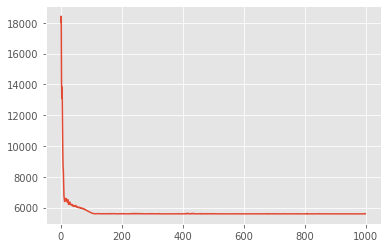

In [21]:
plt.plot(losses)

In [22]:
post_pred_dist = model.get_posterior_predictive_distribution(posterior_distribution=approx_posterior)
post_pred_samples = post_pred_dist.sample(1000)
preds = pd.DataFrame({'y{}'.format(i+1): y_i for i, y_i in enumerate(tf.unstack(post_pred_samples['y'], axis=1))})
preds.head()

,y1,y2
0,-1.180326,23.884560
1,0.718833,6.817953
2,6.689150,14.767899
3,4.763041,6.527788
4,3.652190,16.564213


In [23]:
preds.mean()

y1    0.897254
y2    7.148449
dtype: float32

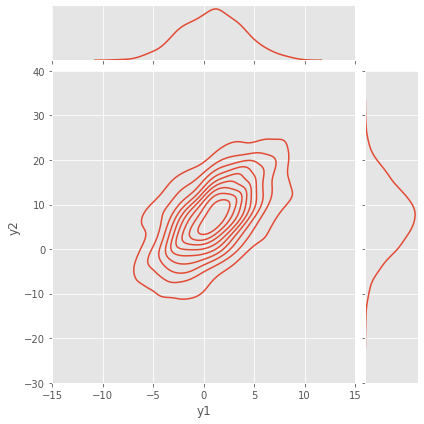

In [24]:
sns.jointplot(x=preds['y1'], y=preds['y2'], kind='kde', xlim=(-15,15), ylim=(-30,40))